In [21]:
import pandas as pd
import numpy as np

import pymorphy2 
import gensim

from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
%matplotlib inline

import sys
import os

### Загрузка данных для тестирования моделей

In [209]:
data = pd.read_csv('./data/hj.csv')

In [210]:
data.head()

,word1,word2,sim
0,автомобиль,машина,0.958333
1,маг,волшебник,0.958333
2,доллар,бакс,0.952381
3,мальчик,парень,0.952381
4,машина,автомобиль,0.952381


In [211]:
y = data['sim'].values
data = data.drop(['sim'], axis=1)

### Определение части речи при помощи Pymorphy2

In [4]:
class NormalAnalyzer:
    __stemmer = pymorphy2.MorphAnalyzer()
    __cache = {}
    
    __grammars = {'NOUN': '_NOUN',
                'VERB': '_VERB', 'INFN': '_VERB', 'GRND': '_VERB', 'PRTF': '_VERB', 'PRTS': '_VERB',
                'ADJF': '_ADJ', 'ADJS': '_ADJ',
                'ADVB': '_ADV'}
    
    __grammars_keys = __grammars.keys()
    
    def norm(self, token):
        token = token.strip().decode('utf-8')
        
        norm = ''
        if token not in self.__cache:
            res = self.__stemmer.parse(token)[0]
            if res.tag.POS in self.__grammars_keys:
                norm = res.normal_form.replace(u'ё', u'е').replace('c', u'с')
                
                norm = norm + self.__grammars[res.tag.POS]
#                 if self.__grammars[res.tag.POS] != '_NOUN':
#                     print norm
            else: 
#                 print token
                norm = res.normal_form.replace(u'ё', u'е')
                norm = norm + '_' + 'UNKN'
            self.__cache[token] = norm
        else :
            norm = self.__cache[token]
        return norm
    
normal_analizer = NormalAnalyzer()

In [5]:
def clean_word(word):
    return word.split('_')[0]

### Подсчет расхождений полученных предсказаний и значений данного датасета

Используемая метрика: MSE - Mean squared error
$$MSE=\frac{1}{n}\sum_{i=1}^{n}({predict}_{i}-y_i)^{2}$$

In [7]:
# __ Предварительна нормализация полученных списков результатов __
def accuracy_norm(predict, y):
    predict = (predict - min(predict)) / (max(predict) - min(predict))
    y = y / max(y)
    return mean_squared_error(predict, y)

In [8]:
def accuracy(predict, y):
    return mean_squared_error(predict, y)

### Некоторые функции печати

In [6]:
# __ Печать списка ненайденных пар __
def print_undefined(undefinded):
    if len(undefinded) != 0:
        print "Список ненайденных пар:\n"
        for words in undefinded:
            print clean_word(words[0]) + ' - ' + clean_word(words[1])
    print '\nВсего не найдено: %d' %len(undefinded)

In [195]:
# __ Печать ошибки по используемой метрике MSE __
def print_accuracy(predict, y):
    print "Нормализованные предсказания: "
    print accuracy_norm(predict, y) 
    print 
    print "Абсолютные предсказания: "
    print accuracy(predict, y) 

### Функции для тестирования

In [197]:
# __ Предсказания данных (data) моделью (model) __
# ____ Output: predict - список предсказаний
#              undefinded - список объектов, которые невозможно предсказать 

def predict(model, data):
    predict = []
    undefinded = []
    for item in data.values:
        word1 = normal_analizer.norm(item[0])
        word2 = normal_analizer.norm(item[1])
        try:
            predict.append(model.similarity(word1, word2))
        except:
            undefinded.append([word1, word2])
            predict.append(0)
    return predict, undefinded

In [299]:
# __ Построение графиков: гистограмма по MSE, 
#                         гистограмма по абсолютной ошибке 
# __

def plot_graphs(predict, y):
    param_weight = 0.4
    param_bins_MSE = np.arange(0, 0.4, 0.025)
    param_bins_Absolute= np.arange(-0.8, 0.5, 0.025)
    param_alpha = 0.65
    
    errors = np.array(predict - y)

    f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
    ax1.hist(errors**2, bins=param_bins_MSE + 0.02 / 2, alpha=param_alpha, edgecolor='black', color='g', rwidth=param_weight)
    ax1.axvline((errors**2).mean(), color='y', linestyle='dashed', linewidth=2)
    ax1.set_xlabel('MSE', fontsize=20)
    ax1.set_ylabel('Number of objects', fontsize=20)
    # ax1.set_title('')
    
    ax2.hist(errors, bins=param_bins_Absolute, alpha=param_alpha, edgecolor='black', color='g')
    ax2.axvline(errors.mean(), color='y', linestyle='dashed', linewidth=2)
    ax2.set_xlabel('Absolute error', fontsize=20)

    predict = (predict - min(predict)) / (max(predict) - min(predict))
    y = y / max(y)
    errors = np.array(predict - y)
    
    ax1.hist(errors**2, bins=param_bins_MSE, alpha=param_alpha, edgecolor='black', rwidth=param_weight)
    ax1.axvline((errors**2).mean(), color='y', linestyle='dashed', linewidth=2)
    ax1.set_xlabel('MSE', fontsize=20)
    ax1.set_ylabel('Number of objects', fontsize=20)
    # ax1.set_title('')
    
    ax2.hist(errors, bins=param_bins_Absolute, alpha=param_alpha, edgecolor='black')
    ax2.axvline(errors.mean(), color='y', linestyle='dashed', linewidth=2)
    ax2.set_xlabel('Absolute error', fontsize=20)


    
    # errors = reduce(lambda er, elem: er + [elem + er[-1]], errors[1:], [errors[0]])
    # ax2.plot(np.arange(len(errors)), errors)
    

    plt.show()

### Тестирование моделей Word2Vec

#### Модель №1

Используется word2vec, обученный на **Национальном Корпусе Русского Языка** от "января 2017". 

| Параметр | Значение |       
| :- |:- |
| Объем словаря | 250 миллионов слов |
| Частотный порог | 10 |
| Алгоритм | Skip-gram |
| Размерность вектора | 300 |
| Размер окна | 10 |

In [198]:
model = gensim.models.KeyedVectors.load_word2vec_format('./ruscorpora_1_300_10.bin', binary=True)

In [199]:
#  __ Предсказания первой модели близости пар нашего датасета __
predicts, undefinded = predict(model, data)

# __ Вывод ненайденных пар __
print_undefined(undefinded)

Список ненайденных пар:

водка - джина
блядь - секс
сто - процент
начать - матч
приют - дурд
погост - дурд
семь - серия
смерть - заключенный
подписать - перерыв
пять - месяц
начать - год
фонд - cd

Всего не найдено: 12


In [207]:
# __ Оцениваем близость предсказаний по размеченным данным __
print_accuracy(predicts, y)

Нормализованные предсказания: 
0.0409589842415

Абсолютные предсказания: 
0.0376676705116


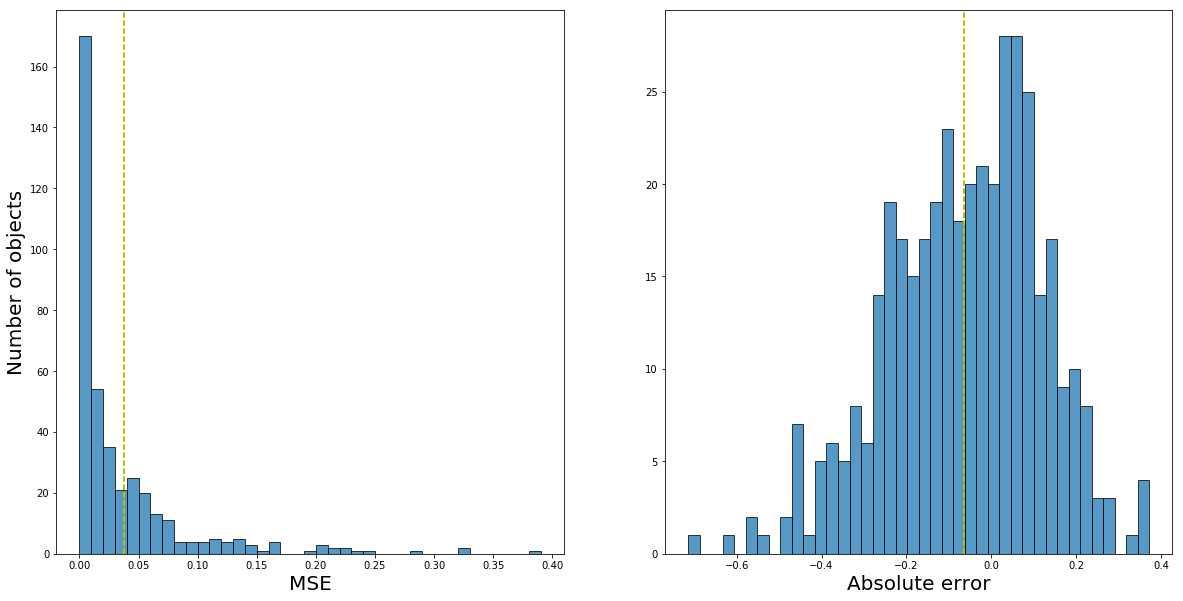

In [201]:
plot_graphs(predicts, y)

#### Модель №2

Используется word2vec, обученный на **Национальном Корпусе Русского Языка и Википедии** от "января 2017". 

| Параметр | Значение |       
| :- |:- |
| Объем словаря | 600 миллионов слов |
| Частотный порог | 15 |
| Алгоритм | CBOW |
| Размерность вектора | 300 |
| Размер окна | 20 |

In [10]:
model = gensim.models.KeyedVectors.load_word2vec_format('./ruwikiruscorpora_0_300_20.bin', binary=True)

In [205]:
#  __ Предсказания первой модели близости пар нашего датасета __
predicts, undefinded = predict(model, data)

# __ Вывод ненайденных пар __
# print_undefined(undefinded)

In [208]:
# __ Оцениваем близость предсказаний по размеченным данным __
print_accuracy(predicts, y)

Нормализованные предсказания: 
0.0409589842415

Абсолютные предсказания: 
0.0376676705116


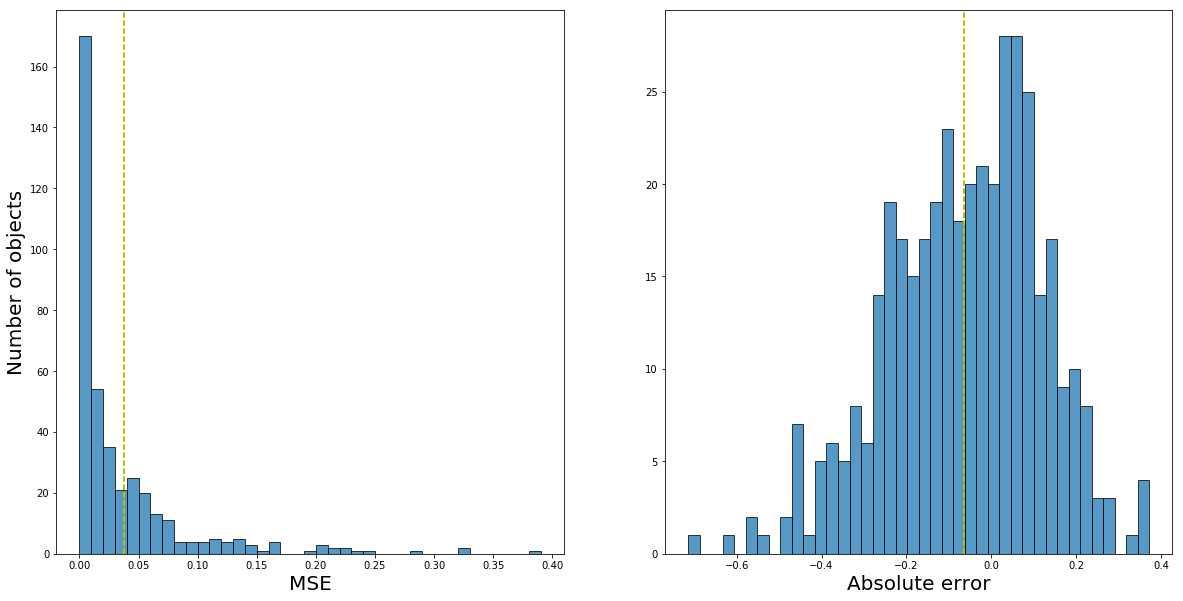

In [201]:
plot_graphs(predicts, y)

#### Модель №3

Используется word2vec, обученный на **Веб-корпусе** от "декабрь 2017". 

| Объем словаря | Частотный порог | Алгоритм | Размерность вектора | Размер окна |
| :-: |:-: |:-: |:-: |:-: |
| 900 миллионов слов | 30 | CBOW | 300 | 20 |

In [212]:
model = gensim.models.KeyedVectors.load_word2vec_format('./web.bin', binary=True)

In [213]:
#  __ Предсказания первой модели близости пар нашего датасета __
predicts, undefinded = predict(model, data)

# __ Вывод ненайденных пар __
# print_undefined(undefinded)

In [214]:
# __ Оцениваем близость предсказаний по размеченным данным __
print_accuracy(predicts, y)

Нормализованные предсказания: 
0.0394952472687

Абсолютные предсказания: 
0.0554176713588


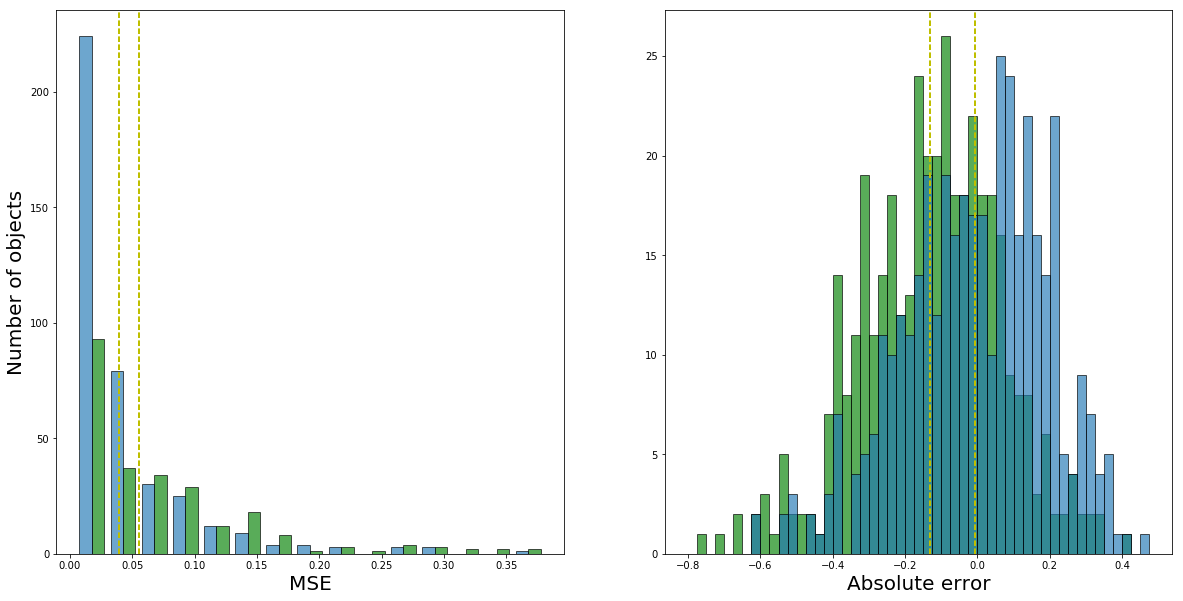

In [300]:
plot_graphs(predicts, y)

### Тест

In [81]:
!mystem

/bin/sh: mystem: command not found


In [99]:
try:
    model.most_similar(u'заключенный_NOUN')
except:
    print "Не найдено"

Не найдено


In [159]:
a = [1,2,3]
a.append(5)

In [239]:
print np.arange(0,1,0.2) +0.05

[ 0.05  0.25  0.45  0.65  0.85]
